In [7]:
import findspark
findspark.init()
import pandas as pd
from pyspark.sql.functions import col, explode
from pyspark import SparkContext

### Initiate spark session

In [8]:
from pyspark.sql import SparkSession
sc = SparkContext
# sc.setCheckpointDir('checkpoint')
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

# 1. Load data

In [9]:
data = spark.read.csv("/home/ksn38/data/transaction_data.csv", header=True)
data = data.toDF(*[col.lower() for col in data.columns])
data = data.withColumnRenamed('product_id','item_id').withColumnRenamed('household_key','user_id')
data.show(3)

+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
|user_id|  basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|trans_time|week_no|coupon_disc|coupon_match_disc|
+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
|   2375|26984851472|  1|1004906|       1|       1.39|     364|       -0.6|      1631|      1|          0|                0|
|   2375|26984851472|  1|1033142|       1|       0.82|     364|          0|      1631|      1|          0|                0|
|   2375|26984851472|  1|1036325|       1|       0.99|     364|       -0.3|      1631|      1|          0|                0|
+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
only showing top 3 rows



In [10]:
data.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- basket_id: string (nullable = true)
 |-- day: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- sales_value: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- retail_disc: string (nullable = true)
 |-- trans_time: string (nullable = true)
 |-- week_no: string (nullable = true)
 |-- coupon_disc: string (nullable = true)
 |-- coupon_match_disc: string (nullable = true)



In [11]:
data = data.\
    withColumn('user_id', col('user_id').cast('integer')).\
    withColumn('basket_id', col('basket_id').cast('integer')).\
    withColumn('day', col('day').cast('integer')).\
    withColumn('item_id', col('item_id').cast('integer')).\
    withColumn('quantity', col('quantity').cast('integer')).\
    withColumn('sales_value', col('sales_value').cast('float')).\
    withColumn('store_id', col('store_id').cast('integer')).\
    withColumn('retail_disc', col('retail_disc').cast('float')).\
    withColumn('week_no', col('week_no').cast('integer')).\
    withColumn('coupon_disc', col('coupon_disc').cast('integer')).\
    withColumn('coupon_match_disc', col('coupon_match_disc').cast('float')).\
    drop('trans_time')
data.show(3)

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|   2375|     null|  1|1004906|       1|       1.39|     364|       -0.6|      1|          0|              0.0|
|   2375|     null|  1|1033142|       1|       0.82|     364|        0.0|      1|          0|              0.0|
|   2375|     null|  1|1036325|       1|       0.99|     364|       -0.3|      1|          0|              0.0|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
only showing top 3 rows



In [12]:
data.describe().show()

+-------+------------------+---------+------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+--------------------+--------------------+
|summary|           user_id|basket_id|               day|          item_id|          quantity|       sales_value|         store_id|        retail_disc|           week_no|         coupon_disc|   coupon_match_disc|
+-------+------------------+---------+------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+--------------------+--------------------+
|  count|           2595732|        0|           2595732|          2595732|           2595732|           2595732|          2595732|            2595732|           2595732|             2595732|             2595732|
|   mean|1271.9525170549193|     null| 388.7562217517063|2891435.159594673| 100.4285581100052|3.1041197828967073|3142.673210870768|-0.53870539843797

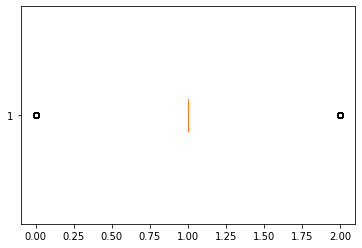

In [13]:
import matplotlib.pyplot as plt

quantity_arr = [int(x.quantity) for x in data.select('quantity').where(col('quantity') < 3).collect()]
plt.boxplot(quantity_arr, vert=False)
plt.show()

In [14]:
data.select('quantity').where(col('quantity') > 3).count()/data.select('quantity').count()

0.035043679393712446

In [15]:
data2 = data.select('*').where(col('quantity') < 3)
data2.show()

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|   2375|     null|  1|1004906|       1|       1.39|     364|       -0.6|      1|          0|              0.0|
|   2375|     null|  1|1033142|       1|       0.82|     364|        0.0|      1|          0|              0.0|
|   2375|     null|  1|1036325|       1|       0.99|     364|       -0.3|      1|          0|              0.0|
|   2375|     null|  1|1082185|       1|       1.21|     364|        0.0|      1|          0|              0.0|
|   2375|     null|  1|8160430|       1|        1.5|     364|      -0.39|      1|          0|              0.0|
|   2375|     null|  1| 826249|       2|       1.98|     364|       -0.6|      1|          0|           

In [16]:
# test_size_weeks = 7

# data_train = data[data['week_no'] < data['week_no'].max() - val_lvl_1_size_weeks]
# data_test = data[(data['week_no'] >= data['week_no'].max() - val_lvl_1_size_weeks)]

## Calculate sparsity

In [17]:
# Count the total number of data in the dataset
numerator = data.select("quantity").count()
print('numerator', numerator)

# Count the number of distinct userIds and distinct movieIds
num_users = data.select("user_id").distinct().count()
num_items = data.select("item_id").distinct().count()
print('num_users', num_users)
print('num_items', num_items)

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_items
print('denominator', denominator)

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The data dataframe is ", "%.2f" % sparsity + "% empty.")

numerator 2595732
num_users 2500
num_items 92339
denominator 230847500
The data dataframe is  98.88% empty.


## Interpret ratings

## Build Out An ALS Model

In [18]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [19]:
# Create test and train set
(train, test) = data.randomSplit([0.8, 0.2], seed = 1234)

# Create ALS model
als = ALS(userCol="user_id", itemCol="item_id", ratingCol="quantity", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

## Tell Spark how to tune your ALS model

In [20]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="quantity", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


## Build your cross validation pipeline

In [21]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Confirm cv was built
print(cv)

CrossValidator_e28d3a415510


## Best Model and Best Model Parameters

In [22]:
import time

t1 = time.time()

In [23]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [24]:
time.time() - t1

6476.363801956177

In [25]:

# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

# # Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 10
  MaxIter: 10
  RegParam: 0.15


In [26]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

1158.773904555886


In [27]:
test_predictions.show()

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+----------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc|prediction|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+----------+
|   1420|     null|377|  67861|       1|       3.39|    3297|        0.0|     55|          0|              0.0|       0.0|
|   1675|     null|210| 307982|       1|       1.99|    3235|       -0.3|     31|          0|              0.0| 0.6391565|
|    916|     null|692| 582680|       1|        1.0|   32269|      -0.03|    100|          0|              0.0|       0.0|
|   1346|     null|551| 700037|       1|        1.5|     208|      -0.79|     79|          0|              0.0|       0.0|
|    604|     null|185| 827148|       1|       9.99|     359|        0.0|     27|          0|              0.0| 0.7298954|
|     74|     nu

## Make Recommendations

In [44]:
# Generate n Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|   1580|[[26190, 0.0], [2...|
|    471|[[1281640, 0.0], ...|
|   1591|[[26190, 0.0], [2...|
|   1342|[[26190, 0.0], [2...|
|   2122|[[26190, 0.0], [2...|
|   2142|[[26190, 0.0], [2...|
|    463|[[1281640, 0.0], ...|
|    833|[[1281640, 0.0], ...|
|   1645|[[6533889, 9640.7...|
|    496|[[6533889, 14535....|
+-------+--------------------+



In [46]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('user_id', col("rec_exp.item_id"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+-------+-------+------+
|user_id|item_id|rating|
+-------+-------+------+
|   1580|  26190|   0.0|
|   1580|  26540|   0.0|
|   1580|  27030|   0.0|
|   1580|  27160|   0.0|
|   1580|  27510|   0.0|
|   1580|  27760|   0.0|
|   1580|  27860|   0.0|
|   1580|  27960|   0.0|
|   1580|  28200|   0.0|
|   1580|  29340|   0.0|
+-------+-------+------+



## Do the recommendations make sense?
Lets merge movie name and genres to teh recommendation matrix for interpretability.

In [47]:
# nrecommendations.join(item_id, on='item_id').filter('user_id = 100').show()

In [48]:
# ratings.join(item_id, on='item_id').filter('user_id = 100').sort('rating', ascending=False).limit(10).show()